# P2 - Continuous Control

---

In this notebook, I will describe my solution to the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

## Learning Algorithm.

I have chosen the multi-agent version of the problem, as it sounded like a better approach to being able to apply any solution like this to my field of work (AAA videogame industry).

The algorithm I selected is **Deep Deterministic Policy Gradient (DDPG)**. This is a good continuation to my solution for (P1 - Navigation), as I had then implemented Deep Q-Network (DQN) to solve that problem. The algorithm is described in the paper ["Continuous Control With Deep Reinforcement Learning"](https://arxiv.org/pdf/1509.02971.pdf)

As in DQN, DDPG utilizes a replay buffer to help comply with the [IID assumption](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables). By storing our observations in a buffer, and sampling batches from that buffer, we get experiences that are less correlated. In this implementation, I have re-used the ReplayBuffer that I implemented for P1.

DDPG combines the ideas from DQN and Deterministic Policy Gradient (DPG). The latter allows us to solve continuous action space problems.

Like an Actor-Critic method, DDPG uses two networks. 
* Actor - selects an action to take given a state
* Critic - it "scores" the action selected by the actor, predicting "how good" the action is

To separate calculations and work with more stationary targets, DQN used a second, separate network (**target network**) that lags behind the network we are using to train (**local network**). The weights of the local network are copied onto the target network, but this process only happens every few steps (**hard update**); we could also interpolate the values to try and get closer to the online ones (**soft update**), which is the option we have selected for this project. Either option will effectively "lock" our targets in place during that time.

In DDPG, because we have two distinct networks, we need to keep our "target" and "local" versions of both Actor and Critic to add stability to the training.

To allow some exploration in the Actor, we use an **Ornstein-Uhlenbeck process** for generating noise that will be added to our selected actions. It samples noise from a correlated normal distribution.

The algorithm works as follows:
![title](img/ddpg.png)


### Implementation details

To improve readability, the code has been split into different files:

* agent_ddpg.py
* model_ddpg.py
* replay_buffer.py
* ounoise.py

These files are commented to help make that code self-explanatory.

However, it is important to note here that since we are solving the multiagent version of the problem, the algorithm differs slightly from a traditional DDPG implementation. In our case, the environment will give us information for every agent at once, which means we do not deal with a single "state, action, reward, next_state, done" tuple, but with a list of them. 

In agent_ddpg.py - AgentOverlord::step, we add all of the experiences for all of the agents to the Replay Buffer before we try to learn from it. The rest of the algorithm is similar, but in our case we are generating multiple actions at once (one per agent) based on the lists of observations we receive from the environment.

## Architecture and hyperparameters

- Our Actor:
    - Uses a deep neural network with:
    -- An *input layer* with **33 nodes**.
    -- **Two** *hidden layers* with **128 nodes each**.
    -- An *output layer* with **4 nodes**.
    - Applies **batch normalization** on each layer
    - Uses **ReLU** as the activation function of the first two layers, and **Tanh** for the third layer. The latter was selected because the actions are composed of four continuous values in the range [-1..1]
    
    
- Our Critic:
    - Uses a deep neural network with:
    -- An *input layer* with **33 nodes**.
    -- A hidden layer with **256 nodes** + **4 extra inputs** to incorporate the action selected by the actor. 
    -- An extra hidden layer with **256 nodes**
    -- An *output layer* with **1 node**.
    - Only the input layer is batch normalized.
    - We use **ReLU** as the activation function.

- We use an **Adam optimizer**

- We use the following hyperparameters:
    - *Gamma* (discount factor): **0.99**
    - *Tau* (we use a soft update to update the weights of the target network): **1e-3**
    - *Actor Learning Rate*: **1e-3**
    - *Critic Learning Rate*: **1e-3**
    - *Batch size*: **128**
    
- Lastly, our *replay buffer* size is **1e5**.


## Training

First, let's initialize the Unity environment.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from agent_ddpg import AgentOverlord
import matplotlib.pyplot as plt
import torch as T
import torch.nn.functional as F
from collections import deque

# Initialize the environment - please note we're using v2 of the problem (multiple agents)
env = UnityEnvironment( file_name='Reacher_Windows_x86_64/Reacher.exe' )

# Get brain - this will be used to control the unity environment
brain_name = env.brain_names[ 0 ]
brain = env.brains[ brain_name ]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


###  Agent initialization

From the description of the problem, we know that:

> "In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible. 
The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`."

With this information, let's initialize our agents and get prepared to solve the problem (in this implementation, we are actually adding an "agent overlord" that will keep track of all of our agents).


In [2]:
# reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]

# number of agents
num_agents = states.shape[ 0 ]
print('Number of agents:', num_agents)

# hyperparameters
actor_hidden = [128, 128]
actor_activation = [F.relu, F.relu, T.tanh]

critic_hidden = [256, 256]

gamma = 0.99
tau = 1e-3
actor_learning_rate = 1e-3
critic_learning_rate = 1e-3
buffer_size = int(1e5)
batch_size= 128
seed = 19

# Initialize device
device = T.device("cuda:0" if T.cuda.is_available() else "cpu")

# initialize overlord
agent_overlord = AgentOverlord( device, 
                                state_size, action_size, num_agents, 
                                actor_hidden, actor_activation,
                                critic_hidden, 
                                gamma, tau, actor_learning_rate, critic_learning_rate, 
                                buffer_size, batch_size, 
                                seed )


Size of each action: 4
Number of agents: 20


### Solving the problem

We are now ready to start solving the problem.

We are setting a maximum number of episodes of *1500*. The minimum mean score over the last *100* episodes needs to be over *30*, as described in the problem, to consider the experiment a success.

Episode 100	Average Score: 17.56
Episode 165	Average Score: 30.01Sucess in 165 episodes!
Mean score was: 30.01, above the criterium 30.00.


<function matplotlib.pyplot.show(close=None, block=None)>

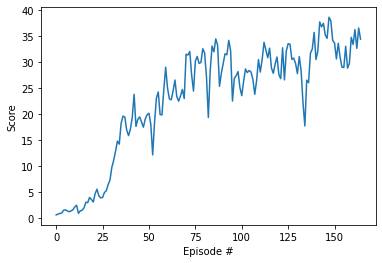

In [3]:
MAX_EPISODES = 1500
MIN_SUCCESS_MEAN_SCORE = 30

EPISODE_RANGE_COUNT = 100

scores_deque = deque(maxlen=EPISODE_RANGE_COUNT)
scores = []
last_mean_score = 0.5

success = False
for episode in range(1,MAX_EPISODES):
    
    # let's restart the environment and get the initial states of the agents
    env_info = env.reset( train_mode=True )[ brain_name ]    
    states = env_info.vector_observations
    score = np.zeros(num_agents)
    agent_overlord.reset()

    while True:

        # choose the actions we should take
        actions = agent_overlord.act( states )

        # apply them
        env_info = env.step( actions )[ brain_name ]

        next_states = env_info.vector_observations

        rewards = env_info.rewards
        dones = env_info.local_done

        # update the overlord
        agent_overlord.step( states, actions, rewards, next_states, dones )

        # update states for next iteration
        states = next_states

        score += env_info.rewards

        if np.any( dones ):
            # episode is done
            break

    # Mean score over all agents
    mean_score = np.mean(score)

    scores_deque.append(mean_score)           
    scores.append(mean_score)
    
    # Calculate the mean score so far 
    mean_score_so_far = np.mean(scores_deque)
        
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, mean_score_so_far), end="")
    if episode % EPISODE_RANGE_COUNT == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, mean_score_so_far))

    # If our deque is full, this means we have enough episodes to potentially end the experiment.
    # In that case, if the mean of the scores in the last episodes is over the success criterium
    if len(scores_deque) == EPISODE_RANGE_COUNT and mean_score_so_far > MIN_SUCCESS_MEAN_SCORE:
        # End experiment
        success = True
        break
    
if success:
    print("Sucess in {:d} episodes!".format(episode))
    print( "Mean score was: {:.2f}, above the criterium {:.2f}.".format(mean_score_so_far, MIN_SUCCESS_MEAN_SCORE))
    
    # Save the trained model
    agent_overlord.save()
else:
    print("We did not reach the desired score {:.2f}/{:.2f}".format(mean_score_so_far, MIN_SUCCESS_MEAN_SCORE))

# Plot a figure showing the mean score per episode
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show

### 4. Test

If our experiment succeeded in the previous step, that means we now have a trained model. Let's  the environment once more, and look at how the agents perform in real-time for one episode. 

In [5]:
# Now, load the saved model
# - Actually, we don't need to do this, as the overlord is still loaded at this point
# - But this is what we would have to do if we need to load it from file
# agent_overlord.reset()
# agent_overlord.load()

env_info = env.reset( train_mode=False )[ brain_name ]    
states = env_info.vector_observations
    
while True:
    # choose the actions we should take
    actions = agent_overlord.act( states )

    # apply them
    env_info = env.step( actions )[ brain_name ]

    dones = env_info.local_done
    if np.any( dones ):
        # episode is done
        break
    
    # update states for next iteration
    states = env_info.vector_observations

In [6]:
# And, finally, close the environment
env.close()

This is a video recording of the test results running in Unity.

In [9]:
from IPython.display import IFrame

IFrame(src='https://www.youtube.com/watch?v=O17ooxWvI3Q', width='560', height='315')

## Ideas for future work

The first thing we could try to improve our solution is to study the effects of the different hyperparameters on the results we obtain. Could we use more hidden layers? Larger or shorter ones? Are our tau, gamma, etc. correct, or can we choose something better?

Secondly, I mentioned I worked in AAA videogames. The solution chosen uses a Replay Buffer, which can potentially consume a lot of memory (depending on the problem). Multithreading a solution can sometimes be easier than optimizing its memory usage. This makes algorithms such as **Advantage Actor-Critic (A3C)** interesting, as they do not rely on "memory" to fight correlation, but instead use the observations of multiple independent agents.

It would be interesting to compare the performance and results of these two different approaches, as well of their memory requirements, to get more data that can inform whether this type of RL is feasible for a modern AAA videogame.